In [1]:
from __future__ import annotations

import itertools
import logging
import os
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
import numpy as np
import pandas as pd
from scipy.stats import norm

import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

from golds.contracts import Currency, Stock, Option, OptionFlavor, OptionStyle, Holdings, Valuation
from golds.env import AmericanOptionEnv
from golds.mkt_data import PricingSource, SingleStockGBMMarketDataSource
from golds.params import GBMParams
from golds.reward_functions import NaiveHedgingRewardFunction, RewardFunction
from golds.tcost import NaiveTransactionCostModel

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [4]:
class DDQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        obs_input: pd.DataFrame,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False
        
        self.obs_input = obs_input

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 1000):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0
        rewards = []

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
                
            if frame_idx % plotting_interval == 0:
                prev_pos = None
                preds = []
                
                for _t in sorted(self.obs_input['normalized_time'].unique()):
                    prev_pos = np.ones(self.obs_input['episode_idx'].max() + 1) * 100 if prev_pos is None else prev_pos
                    obs = np.hstack([self.obs_input.loc[self.obs_input['normalized_time'] == _t, ['price', 'call_price','all_1', 'normalized_time',]].values, prev_pos[:, np.newaxis], np.zeros((self.obs_input['episode_idx'].max() + 1, 2))])
                    pred = np.zeros(len(obs))
                    for j in range(len(obs)):
                        pred[j] = self.select_action(obs[j]) - 100
                    prev_pos = pred
                    preds.append(pred)
                    
                self.obs_input['holdings'] = np.concatenate(preds)
                self.obs_input = self.obs_input.sort_values(['episode_idx', 'normalized_time'])
                self.obs_input = self._calculate_reward_vectorize(self.obs_input)
                
                action_fn_df: pd.DataFrame = self.obs_input[['holdings', 'reward']]
                    
                reward_value = action_fn_df.reward.median()
                    
                rewards.append(reward_value)
                
                stock_price_list = [98, 100, 102]

                for price in stock_price_list:   
                    mu = 0.02 / 252
                    sigma = 0.09 / np.sqrt(252)
                    r = 0.0 / 252

                    stock_holdings = np.arange(-100,-19)
                    obs_length = len(stock_holdings)
                    stock_price = np.repeat(price, obs_length)
                    obs_3 = np.repeat(1, obs_length)
                    time_to_maturity = np.repeat(49 / 252, obs_length)
                    obs_6 = np.repeat(0, obs_length)
                    obs_7 = np.repeat(0, obs_length)
                    t = 49/50

                    res = pd.DataFrame.from_dict({'stock_price': stock_price, 'obs_3': obs_3, 'stock_holdings': stock_holdings, 
                                             'time_to_maturity':time_to_maturity, 'obs_6': obs_6,'obs_7': obs_7, 't':t})
                    res['delta'] = norm.cdf((np.log(res['stock_price'] / 100) + (r * 252 + 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) /\
                        np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))
                    res['call_price'] = res['stock_price'] * res['delta'] - 100 * np.exp(-r * 252 * (1 - res['time_to_maturity'])) * norm.cdf((np.log(res['stock_price'] / 100)\
                         + (r * 252 - 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) / np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))

                    obs = res[["stock_price","call_price","obs_3","t","stock_holdings","obs_6","obs_7"]].to_numpy()
                    
                    actions = np.zeros(len(obs))
                    for j in range(len(obs)):
                        actions[j] = self.select_action(obs[j]) - 100

                    if price < 100:
                        oom_actions = list(actions)
                    elif price == 100:
                        atm_actions = list(actions)
                    else:
                        itm_actions = list(actions)
                
                self._plot(frame_idx, scores, rewards, losses, epsilons, oom_actions, atm_actions, itm_actions)
                
        self.env.close()
                
    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss
    
    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        rewards: List[float], 
        losses: List[float], 
        epsilons: List[float],
        oom_actions: List[float],
        atm_actions: List[float],
        itm_actions: List[float]
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(10, 25))
        plt.subplot(411)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(412)
        plt.title('frame %s. ' % (frame_idx))
        plt.plot(rewards, marker='x')
        plt.semilogx()
        plt.subplot(413)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(414)
        stock_holdings = np.arange(-100,-19)
        delta_oom = - stock_holdings
        delta_atm = -50 - stock_holdings
        delta_itm = -100 - stock_holdings
        plt.title('policy plot')
        plt.plot(stock_holdings, delta_oom, ls="-" , label="Delta Out of Money", color="red") 
        plt.plot(stock_holdings, delta_atm, ls="-" , label="Delta At The Money", color="blue") 
        plt.plot(stock_holdings, delta_itm, ls="-" , label="Delta In The Money", color="green") 
        plt.scatter(stock_holdings, oom_actions - stock_holdings, label="DQN Out of Money", color="red", s=8) 
        plt.scatter(stock_holdings, atm_actions - stock_holdings, label="DQN At The Money", color="blue", s=8) 
        plt.scatter(stock_holdings, itm_actions - stock_holdings, label="DQN In The Money", color="green", s=8) 
        plt.gca().invert_xaxis()
        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.5), fancybox=True)
        plt.show()
    
    def _calculate_reward_vectorize(self, res: pd.DataFrame):
        res['delta_wealth'] = res['holdings'].shift() * res['price'] + 100 * res['call_price'] - (res['holdings'] * res['price'] + 100 * res['call_price']).shift()
        res.loc[res['normalized_time']==res['normalized_time'].min(), 'delta_wealth'] = 0.
        res['reward'] = res['delta_wealth'] ** 2 * -0.5 * 0.1
        return res

In [5]:
def get_training_environment(save_dir: str):
    aapl = Stock(ticker="AAPL", is_tradable=True)
    # TODO we can also make the option parameters part of the config
    warrant = Option(
        strike=100,
        expiry_time=1.,
        underlying=aapl,
        flavor=OptionFlavor.CALL,
        style=OptionStyle.EUROPEAN,
        is_tradable=False
    )
    cash = Currency(code="USD", is_tradable=False)

    initial_holdings: Holdings = {
        aapl: 0,
        warrant: 100,
        cash: 0,
    }

    universe = list(initial_holdings.keys())

    gbm_params = GBMParams(mu=0.02, sigma=0.09, risk_free_rate=0.0)

    mkt_data_source = SingleStockGBMMarketDataSource(universe, gbm_params, data_reuse_num_episodes=10000)
    tcost_model = NaiveTransactionCostModel(universe)
    pricing_source = PricingSource(mkt_data_source, tcost_model)

    reward_clip_range = (-200, 200)
    reward_records_save_path = os.path.join(save_dir, "ddqn_reward_history.h5")

    valid_actions = {'lo': -100, 'hi': 100}

    reward_function: RewardFunction = NaiveHedgingRewardFunction(
        kappa=0.1,
        initial_holdings=initial_holdings,
        reward_clip_range=reward_clip_range,
        reward_records_save_path=reward_records_save_path
    )

    return AmericanOptionEnv(
        episode_length=50,
        pricing_source=pricing_source,
        reward_function=reward_function,
        actions_config=valid_actions
    )

In [6]:
def get_evaluation_paths():
    episode_length=50
    nepisodes = 100
    mu=0.02 / 252
    sigma=0.09 / np.sqrt(252)
    r=0.0 / 252
    np.random.seed(42)
    randns = np.random.randn(nepisodes * episode_length)
    res = pd.DataFrame.from_dict({'episode_idx': np.repeat(np.arange(nepisodes), episode_length), 'randn': randns})
    res['time_to_maturity'] = np.tile(1 + np.arange(episode_length), nepisodes) / 252
    res['cum_randn'] = res.groupby('episode_idx')['randn'].cumsum()
    res['price'] = res['cum_randn'] * sigma + (mu - sigma ** 2 / 2 * res['time_to_maturity'] * 252)
    res['price'] = 100 * np.exp(res['price'])
    res['all_1'] = 1.
    res['normalized_time'] = np.tile(1 + np.arange(episode_length), nepisodes) / episode_length
    res['delta'] = norm.cdf((np.log(res['price'] / 100) + (r * 252 + 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) /\
        np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))
    res['call_price'] = res['price'] * res['delta'] - 100 * np.exp(-r * 252 * (1 - res['time_to_maturity'])) * norm.cdf((np.log(res['price'] / 100)\
         + (r * 252 - 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) / np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))
    return res

In [7]:
action_fn_observation_grid = get_evaluation_paths()
obs_input = action_fn_observation_grid.sort_values(['normalized_time', 'episode_idx'])
obs_input

,episode_idx,randn,time_to_maturity,cum_randn,price,all_1,normalized_time,delta,call_price
0,0,0.496714,0.003968,0.496714,100.288355,1.0,0.02,0.530675,3.733329
50,1,0.324084,0.003968,0.324084,100.190248,1.0,0.02,0.526339,3.681479
100,2,-1.415371,0.003968,-1.415371,99.207050,1.0,0.02,0.482563,3.185464
150,3,0.250493,0.003968,0.250493,100.148456,1.0,0.02,0.524490,3.659521
200,4,0.357787,0.003968,0.357787,100.209395,1.0,0.02,0.527186,3.691565
...,...,...,...,...,...,...,...,...,...
4799,95,0.739180,0.198413,-11.553985,93.591638,1.0,1.00,0.217215,0.900958
4849,96,0.479361,0.198413,-6.045505,96.560638,1.0,1.00,0.346769,1.731934
4899,97,0.603791,0.198413,0.306237,100.101251,1.0,1.00,0.521074,3.266244
4949,98,0.434503,0.198413,5.852585,103.298930,1.0,1.00,0.671149,5.177527


In [8]:
save_dir = os.getcwd()
env = get_training_environment(save_dir)
action_space = env.action_space

In [9]:
num_frames = 12500000
memory_size = 10000
batch_size = 32
target_update = 1000
epsilon_decay = 1 / 2000

# train
agent = DDQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, obs_input)

cpu


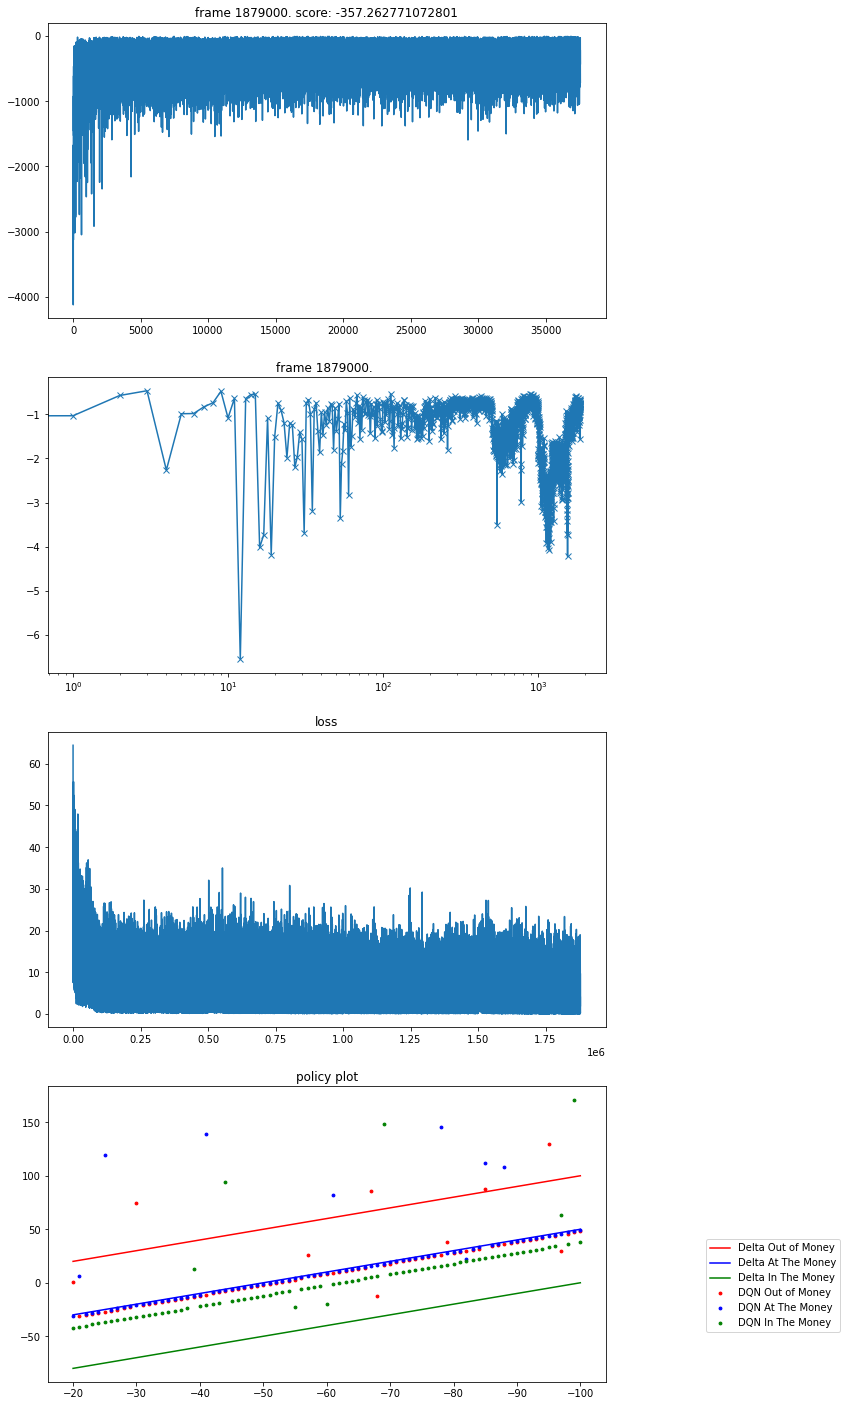

In [ ]:
agent.train(num_frames)

In [ ]:
prev_pos = None
preds = []

for _t in sorted(obs_input['normalized_time'].unique()):
    prev_pos = np.ones(obs_input['episode_idx'].max() + 1) * 100 if prev_pos is None else prev_pos
    obs = np.hstack([obs_input.loc[obs_input['normalized_time'] == _t, ['price', 'call_price', 'all_1','normalized_time',]].values, prev_pos[:, np.newaxis], np.zeros((obs_input['episode_idx'].max() + 1, 2))])
    pred = np.zeros(len(obs))
    for j in range(len(obs)):
        pred[j] = agent.select_action(obs[j]) - 100
    prev_pos = pred
    preds.append(pred)

obs_input['holdings'] = np.concatenate(preds)
obs_input

In [ ]:
obs_input = obs_input.sort_values(['episode_idx', 'normalized_time'])

In [ ]:
def calculate_reward_vectorize(res):
    res['delta_wealth'] = res['holdings'].shift() * res['price'] + 100 * res['call_price'] - (res['holdings'] * res['price'] + 100 * res['call_price']).shift()
    res.loc[res['normalized_time']==res['normalized_time'].min(), 'delta_wealth'] = 0.
    res['reward'] = res['delta_wealth'] ** 2 * -0.5 * 0.1
    return res

In [ ]:
obs_input = calculate_reward_vectorize(obs_input)

obs_input

In [ ]:
sample_experiment = obs_input.query('episode_idx==99')

In [ ]:
sample_experiment

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].plot(np.arange(50), sample_experiment.delta * -100, '-')
axes[0].plot(np.arange(50), sample_experiment.holdings, '*-')
axes[1].plot(np.arange(50), ((sample_experiment['price'].shift(-1) - sample_experiment['price']) * sample_experiment['holdings']).cumsum(), 'v-')
axes[1].plot(np.arange(50), ((sample_experiment['call_price'].shift(-1) - sample_experiment['call_price']) * 100).cumsum(), 'x-')